# Training LeNet-5 In Tensorflow

## Introduction

This notebook describes the building of my implementation of the LeNet-5 model in TensorFlow.

### What is LeNet-5?
LeNet-5 is a convolutional neural network designed for handwritten and machine-printed character recognition. The input is an image of 32x32 pixels, which gets classified into one of 10 categories corresponding to the numbers from 0 to 9. So the input is a tensor of rank 2 with 32x32 elements, whilst the output is a tensor of rank 1 with 10 elements. The architecture of the network is as follows (Lecun, 1988),

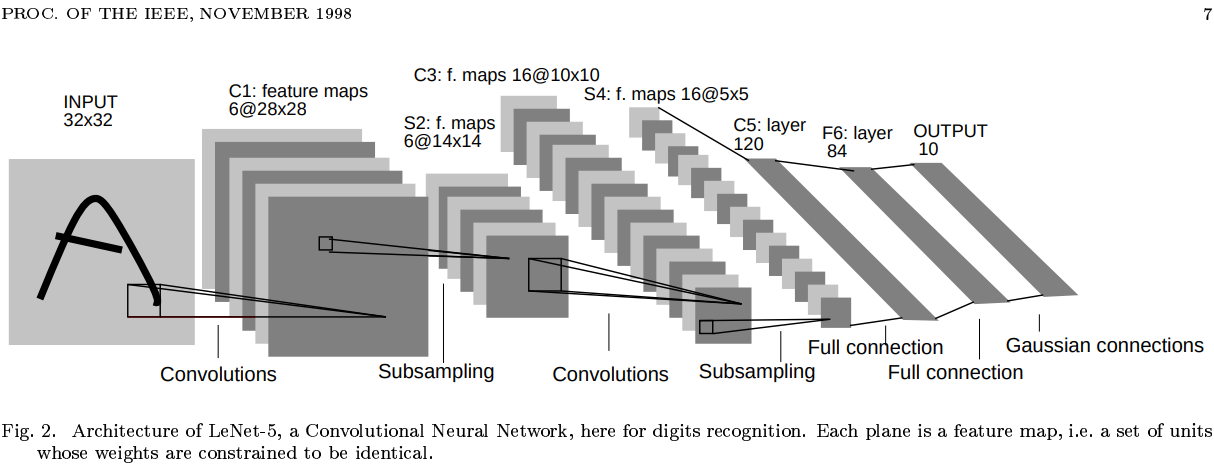

### The German traffic signs problem

The German traffic signs problem, as its consist on the task of classifying range 2 tensors with 32x32 elements into range 1 tensors of 43 elements. This requirement implies some subtle modifications to the architecture of the LeNet-5 Network 

## Libraries

The libraries used to image load and processing are,

* `imageio`
* `OpenCV (cv2)`
* `Numpy`
* `scikit-learn`

Which will be used in the helper functions shown on a section below.

## But first, let there be some parameters defined...

Before declaring the helper functions, I need to place hyperparameters for the model. After several runs of the training, and some manual tunning, I picked the following set of parameters for the training of the LeNet-5,

In [1]:
import tensorflow as tf

# Set parameters
learning_rate = 0.0035
training_iteration = 100
batch_size = 121
display_step = 10
test_size = 0.2

input_image_shape = (32,32)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Helper functions

In order to load the images from the annotations file `gt.txt` I needed a set of helper functions.
The doc-strings on the functions are self-explanatory, but in summary,

* `annotation_parser` : extracts information from an annotation word  
* `get_annotated_ROI` : gets the ROI for a given annotation  
* `create_data_set_from_annotations` : generates a shuffled data set reading from an annotations file  
* `split_data` : splits the data into two batches, for training and testing.  

In [2]:
import os
import cv2
import imageio
import numpy as np
from sklearn.utils import shuffle

def annotation_parser(annotation, sep=";"):
    """
    anotation_parser extracts information of the ROI for a single annotation
    
    Input
    -----
    - annotation(string): The annotation for a single image
    - sep(string): The separator for the annotations. (default ";")
    
    Returns
    -------
    - filename(string): The name of the file corresponding to the annotation
    - left_column(int): Coordinates for left column of the ROI
    - top_row(int): Coordinates of the top row of the ROI
    - right_column(int): Coordinates of the left column of the ROI
    - bottom_row(int): Coordinates of the bottom row of the ROI
    - category(int): The numerical category the image in the ROI belongs to
    
    """
    filename, left_column, top_row, right_column, bottom_row, category = annotation.split(sep)
    return filename, int(left_column), int(top_row), int(right_column), int(bottom_row), int(category)


def get_annotated_ROI(annotation, path="FullIJCNN2013", as_gray=True, sep=";"):
    """
    get_annotated_ROI returns the ROI(an array) provided an annotation (string)
    
    Input
    -----
    - annotation(string): The annotation for a single image
    - path(string): Path containing the image files
    - as_gray(bool): If the image is loaded as RGB or Grayscale
    - sep(string): The separator for the annotations. (default ";")
    
    Returns
    -------
    - img(numpy.array): The ROI
    - category(int): The numerical category the image in the ROI belongs to
    """
    image_file, left_column, top_row, right_column, bottom_row, cat = annotation_parser(annotation, sep)
    image_file = os.path.join(path, image_file)
    img = imageio.imread(image_file, as_gray=as_gray)
    return img[top_row:top_row+(right_column-left_column),left_column:left_column+(bottom_row-top_row)].copy(), cat


def create_data_set_from_annotations(annotations_file, path="FullIJCNN2013", as_gray=True, target_shape = input_image_shape, sep=";"):
    """
    create_data_set_from_annotations Generates a shuffled dataset of ROIs (X) and their labels (y)
    provided an annotations_file corresponding to the german traffic sings dataset
    
    Input
    -----
    - annotation_file(string): The name of annotations file
    - path(string): Path containing the annotations file
    - as_gray(bool): If the image is loaded as RGB or Grayscale
    - target_shape(tuple): Tuple with the expected size of each of the output ROIs'
    - sep(string): The separator for the annotations. (default ";")
    
    Returns
    -------
    - X(numpy.array): Array of ROIs, one for each index
    - y(numpy.array): Array of labels corresponding to each of the ROIs on X
    """
    X = list()
    y = list()
    the_file = os.path.join(path, annotations_file)
    with open(the_file, "r") as annf:
        for line in annf:
            img, cat = get_annotated_ROI(line, path, as_gray, sep)
            img = cv2.resize(img, target_shape)
            # It is needed to add one dimension to have a result 32x32x1
            X.append(np.expand_dims(img, axis=2)) 
            y.append(cat)
            
    X, y = np.array(X), np.array(y)
    X, y = shuffle(X, y)
    return X, y


def split_data(Xo, yo, test_size=test_size):
    """
    split_data splits the data set X, y in two sets train_data, test_data and, train_labels, test_labels
    where the amount of elements of the second set correspond to the `test_size`
    percent of the amount of X, y
    
    Input
    -----
    - X(numpy.array): Array of features
    - y(numpy.array): Array of labels
    - test_size(float): Percentage of split(defalt 0.2)
    
    Returns
    -------
    - train_data(numpy.array) features to train
    - test_data(numpy.array) features to test
    - train_labels(numpy.array) labels of train_data
    - test_labels(numpy.array) labels of test_data
    
    """
    data_size = len(Xo)
    X, y = shuffle(Xo, yo)
    if (len(y) == data_size and test_size*data_size <= data_size) and (test_size <= 1.0):
        train_sz = int((1-test_size)*data_size)
        test_sz = int(test_size*data_size)
        
        train_data = np.zeros((train_sz,) + X.shape[1:])
        train_labels = np.zeros(train_sz)
        test_data = np.zeros((test_sz,) + X.shape[1:])
        test_labels = np.zeros(test_sz)
        
        for e in range(train_sz):
            index = np.random.randint(data_size)
            train_data[e] = X[index]
            train_labels[e] = y[index]
            
        for e in range(test_sz):
            index = np.random.randint(data_size)
            test_data[e] = X[index]
            test_labels[e] = y[index]
            
        return train_data, test_data, train_labels, test_labels
    else:
        print("Size miss_match")
        return Xo, yo, Xo, yo

## Proceed to load the dataset

Using the helper functions, we can load the dataset in one line as,

In [3]:
X, y = create_data_set_from_annotations("gt.txt")

unique_labels = np.array(list(set(y)))

Lets verify the shapes of our datased, features, and labels  

In [4]:
data_shape = X[0].shape
data_shape

(32, 32, 1)

In [5]:
number_of_classes = len(set(y))
number_of_classes

43

# Generate train, validation, and tests data set

By means of `split_data` I can generate three sets, one for training, one for validation, and one for testing

In [6]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=test_size)

The validation and testing sets are obtained from the initial partition 

In [7]:
X_test, X_validation, y_test, y_validation = split_data(X_test, y_test, test_size=0.33)

The number of samples we have to train the model,

In [8]:
n_train_samples = len(X_train)
n_train_samples

970

A quick check that every tensor is of the correct range 

In [9]:
X_train.shape

(970, 32, 32, 1)

In [10]:
y_train.shape

(970,)

In [11]:
X_test.shape

(162, 32, 32, 1)

In [12]:
y_test.shape

(162,)

In [13]:
X_validation.shape

(79, 32, 32, 1)

In [14]:
y_validation.shape

(79,)

# LeNet-5 Adaptation

As mentioned earlier, the German traffic signs requires an adaptation of the LeNet-5 network. Below is the adaptation of the network to output a classification among 43 classes (`number_of_classes`)

In [15]:

from  tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    layer_depth = {
        'layer_1' : 6,
        'layer_2' : 16,
        'layer_3' : 120,
        'layer_f1' : 84
    }

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_w = tf.Variable(tf.truncated_normal(shape = [5,5,1,6],mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x,conv1_w, strides = [1,1,1,1], padding = 'VALID') + conv1_b 
    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    pool_1 = tf.nn.max_pool(conv1,ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_w = tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(pool_1, conv2_w, strides = [1,1,1,1], padding = 'VALID') + conv2_b
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    pool_2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID') 
    
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(pool_2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_w = tf.Variable(tf.truncated_normal(shape = (400,120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc1,fc1_w) + fc1_b
    
    # Activation.
    fc1 = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal(shape = (120,84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1,fc2_w) + fc2_b
    # Activation.
    fc2 = tf.nn.relu(fc2)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43(number_of_classes).
    fc3_w = tf.Variable(tf.truncated_normal(shape = (84, number_of_classes), mean = mu , stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(number_of_classes))
    logits = tf.matmul(fc2, fc3_w) + fc3_b
    
    return logits

Declare the required placeholders for our model 

In [16]:
# TF graph input
x = tf.placeholder(tf.float32, [None, data_shape[0], data_shape[1],1])

In [17]:
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, number_of_classes)

Define the cost function as the reduced mean of the cross entropy with logits. The train_operation holds the cascade of tensorflow operations required to minimize the Adam Optimizer over the cost function

In [18]:
# The model instance for the TF Graph
logits = LeNet(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



The following auxiliary function performs the accuracy calculation using the default session of tensorflow and will be used to evaluate the model against the validation set 

In [19]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Training of the modified LeNet-5

The tensorflow session below performs the training of our model and checks the score against the validation set at each step. The model will be saved at the folder in `model_path`

In [20]:
import os

model_path = "saved_model"
if not os.path.exists(model_path):
    os.mkdir(model_path)

print("About to save the model to '{}'".format(model_path))
    

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(training_iteration):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        if i % display_step == 0:
            print("EPOCH {} of {} ...".format(i+1, training_iteration))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()

    validation_accuracy = evaluate(X_validation, y_validation)
    print("Validation Accuracy at the end of the training= {:.3f}".format(validation_accuracy))
    print()
        
    saver.save(sess, "./{}".format(model_path))
    print("Model saved to '{}'".format(model_path))

About to save the model to 'saved_model'
Training...

EPOCH 1 of 100 ...
Validation Accuracy = 0.127

EPOCH 11 of 100 ...
Validation Accuracy = 0.835

EPOCH 21 of 100 ...
Validation Accuracy = 0.924

EPOCH 31 of 100 ...
Validation Accuracy = 0.899

EPOCH 41 of 100 ...
Validation Accuracy = 0.886

EPOCH 51 of 100 ...
Validation Accuracy = 0.886

EPOCH 61 of 100 ...
Validation Accuracy = 0.861

EPOCH 71 of 100 ...
Validation Accuracy = 0.873

EPOCH 81 of 100 ...
Validation Accuracy = 0.772

EPOCH 91 of 100 ...
Validation Accuracy = 0.924

Validation Accuracy at the end of the training= 0.924

Model saved to 'saved_model'


# Testing the accuracy against the test set

We want to check how well our model performs against a test set, recall that the test set wasn't part of the training of our model. The model will be loaded from the `model_path` directory where it was saved before

In [21]:
print("Ready to load model from '{}'".format(model_path))

with tf.Session() as sess:
    #saver.restore(sess, save_path="./{}".format(model_path))
    saver.restore(sess, save_path=model_path)
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Ready to load model from 'saved_model'
INFO:tensorflow:Restoring parameters from saved_model
Test Accuracy = 0.969


In [22]:
X_test.shape

(162, 32, 32, 1)

# References

* Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner.(1998) _Gradient-based learning applied to document recognition_. Proceedings of the IEEE. November. 1-46 
 